In [1]:
import re
import os
import sys
import time
import numpy as np
import scipy as sp
from utils import *
from math import log
from h5py import File
import mindspore as ms
from numpy.linalg import *
from scipy.linalg import *
from mindquantum.simulator import *
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindspore.common.initializer import *
from mindquantum.algorithm.compiler import *

np.set_printoptions(linewidth=200)

In [2]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Optimal Gap: %.20f, %d, %.4f' % (f, i, t))
    return f, g


def universal_ansatz(obj, str=None):
    circ = Circuit()
    if str is not None:
        name = f'q{obj[0]}_{str}_'
    else:
        name = f'q{obj[0]}_'
    if len(obj) == 2:
        circ += U3(f'{name}U1t', f'{name}U1p', f'{name}U1l').on(obj[1])
        circ += RZ(f'{name}R1').on(obj[0], obj[1])
        circ += U3(f'{name}U2t', f'{name}U2p', f'{name}U2l').on(obj[1])
        circ += RY(f'{name}R2').on(obj[0], obj[1])
        circ += U3(f'{name}U3t', f'{name}U3p', f'{name}U3l').on(obj[1])
        circ += RZ(f'{name}R3').on(obj[0], obj[1])
        circ += U3(f'{name}U4t', f'{name}U4p', f'{name}U4l').on(obj[1])
    else:
        circ += universal_ansatz(obj[1:], 'U1')
        circ += RZ(f'{name}R1').on(obj[0], obj[1:])
        circ += universal_ansatz(obj[1:], 'U2')
        circ += RY(f'{name}R2').on(obj[0], obj[1:])
        circ += universal_ansatz(obj[1:], 'U3')
        circ += RZ(f'{name}R3').on(obj[0], obj[1:])
        circ += universal_ansatz(obj[1:], 'U4')
    return circ


d, m = 3, 2
nq = (d - 1) * m
a = unitary_group.rvs(d**m, random_state=42)
Id = su2_encoding(np.eye(d**m), m)
c = np.eye(Id.shape[0]) - Id
a = su2_encoding(a, m) + c

sim = Simulator('mqvector', nq)
psi0 = sim.get_qs()
psi = a @ psi0
ham = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(ham))

ansatz = universal_ansatz(list(range(nq)))
for i in range(nq):
    ansatz += GlobalPhase(f'phase').on(i)
p_name = ansatz.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)
display_svg(ansatz.svg())

sim.reset()
sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
p0 = np.random.uniform(-1, 1, p_num)
fun(p0, sim_grad)
start = time.perf_counter()
res = minimize(fun, p0, args=(sim_grad, []), method='BFGS', jac=True, tol=1e-6)

print(res.message)
print('Optimal Value: %.20f' % res.fun)

sim.reset()
res_pr = dict(zip(p_name, res.x))
sim.apply_circuit(ansatz.apply_value(res_pr))
psi_res = sim.get_qs()
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))

ansatz.apply_value(res_pr).svg()

Number of qubits: 4
Number of params: 76
Number of gates: 131


Optimal Gap: 0.68574275477763513287, 10, 0.0166
Optimal Gap: 0.43097962567894376740, 20, 0.0281
Optimal Gap: 0.35676607114238345630, 30, 0.0393
Optimal Gap: 0.13877398451267874968, 40, 0.0505
Optimal Gap: 0.04893054848731359652, 50, 0.0616
Optimal Gap: 0.01235420690091437734, 60, 0.0730
Optimal Gap: 0.00179275334251416396, 70, 0.0858
Optimal Gap: 0.00033188103039938355, 80, 0.0971
Optimal Gap: 0.00014157570106632100, 90, 0.1083
Optimal Gap: 0.00001414764572582605, 100, 0.1195
Optimal Gap: 0.00000076007084426344, 110, 0.1315
Optimal Gap: 0.00000002491166017915, 120, 0.1430
Optimal Gap: 0.00000000015815504462, 130, 0.1543
Optimization terminated successfully.
Optimal Value: 0.00000000000108357767
psi norm: 1.08940018064292964972
psi fidelity: 0.99999999999945821116


In [3]:
# Qudit
d = 3
nq = d - 1
n = 2**nq
for i in range(d):
    for j in range(d):
        a = f'a{str(i)}{str(j)}|{str(i)}⟩⟨{str(j)}|'
        print(a, end=' ')
    print()
print()
# Qubit
for i in range(n):
    for j in range(n):
        ii = bin(i)[2:].zfill(nq)
        jj = bin(j)[2:].zfill(nq)
        a = f'a{str(i)}{str(j)}|{ii}⟩⟨{jj}|'
        print(a, end=' ')
    print()

a00|0⟩⟨0| a01|0⟩⟨1| a02|0⟩⟨2| 
a10|1⟩⟨0| a11|1⟩⟨1| a12|1⟩⟨2| 
a20|2⟩⟨0| a21|2⟩⟨1| a22|2⟩⟨2| 

a00|00⟩⟨00| a01|00⟩⟨01| a02|00⟩⟨10| a03|00⟩⟨11| 
a10|01⟩⟨00| a11|01⟩⟨01| a12|01⟩⟨10| a13|01⟩⟨11| 
a20|10⟩⟨00| a21|10⟩⟨01| a22|10⟩⟨10| a23|10⟩⟨11| 
a30|11⟩⟨00| a31|11⟩⟨01| a32|11⟩⟨10| a33|11⟩⟨11| 


In [4]:
# Qudit
d = 4
nq = d - 1
n = 2**nq
print('\\begin{pmatrix}')
for i in range(d):
    for j in range(d):
        a = f'a_{{{str(i)}{str(j)}}}'
        if j < d - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')
print()
# Qubit
ind = {}
for i in range(n):
    num1 = bin(i).count('1')
    ind[i] = [num1]
print(ind)
print('\\begin{pmatrix}')
for i in range(d):
    for j in range(d):
        a = f'a_{{{str(ind[i][0])}{str(ind[j][0])}}}'
        if j < d - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')

\begin{pmatrix}
a_{00} & a_{01} & a_{02} & a_{03} \\
a_{10} & a_{11} & a_{12} & a_{13} \\
a_{20} & a_{21} & a_{22} & a_{23} \\
a_{30} & a_{31} & a_{32} & a_{33} \\
\end{pmatrix}

{0: [0], 1: [1], 2: [1], 3: [2], 4: [1], 5: [2], 6: [2], 7: [3]}
\begin{pmatrix}
a_{00} & a_{01} & a_{01} & a_{02} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{20} & a_{21} & a_{21} & a_{22} \\
\end{pmatrix}


In [5]:
d = 3
n = 2**(d - 1)
a1 = unitary_group.rvs(d)
a2 = su2_encoding(a1)
print(a1)
print(a2)
p = np.eye(n) - su2_encoding(np.eye(d))
print(p)
a2 += p
is_unitary(a2), is_symmetric(a2)

[[ 0.57545538+0.16590746j -0.60864031+0.26254676j  0.43029052-0.12962278j]
 [-0.10319062-0.66173937j -0.00385583-0.3116642j   0.64081083+0.20896109j]
 [-0.32373878+0.29660028j  0.26535201+0.626949j    0.43109755+0.39736589j]]
[[ 0.57545538+0.16590746j -0.43037369+0.1856486j  -0.43037369+0.1856486j   0.43029052-0.12962278j]
 [-0.07296679-0.4679204j  -0.00192792-0.1558321j  -0.00192792-0.1558321j   0.45312168+0.1477578j ]
 [-0.07296679-0.4679204j  -0.00192792-0.1558321j  -0.00192792-0.1558321j   0.45312168+0.1477578j ]
 [-0.32373878+0.29660028j  0.1876322 +0.44331989j  0.1876322 +0.44331989j  0.43109755+0.39736589j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, False)

In [6]:
d = 3
n = 2**(d - 1)
i1 = np.eye(d)
i2 = su2_encoding(i1)
p = np.eye(n) - su2_encoding(np.eye(d))
print(i1)
print(i2)
print(p)
is_symmetric(i2), matrix_rank(i2)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 1. +0.j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, 3)

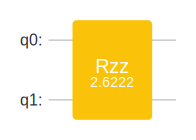

(True, True, True)

In [7]:
# U2⊗U2 Rxx Ryy Rzz SWAP preserve symmetry
d = 3
a1 = unitary_group.rvs(d)
b1 = np.random.rand(d) + 1j * np.random.rand(d)
b1 /= norm(b1)
a2 = su2_encoding(a1)
b2 = su2_encoding(b1)
# print(a1)
# print(a2)
# print(b1)
# print(b2)
t = np.random.uniform(-np.pi, np.pi)
k = Circuit() + Rzz(t).on([0, 1])
# k = Circuit() + UN(UnivMathGate('', unitary_group.rvs(2)), 2)
display_svg(k.svg())
k = k.matrix()
# print(k)
# print(a2 @ k)
# print(k @ a2)
# print(k @ b2)
is_symmetric(a2 @ k), is_symmetric(k @ a2), is_symmetric(k @ b2)

In [8]:
# How to restore a reduce density matrix
np.random.seed(42)
a = np.random.rand(2) + 1j * np.random.rand(2)
b = np.random.rand(2) + 1j * np.random.rand(2)
a /= norm(a)
b /= norm(b)
psi_ab = np.kron(a, b)
rho_a = np.outer(a, a.conj())
rho_b = np.outer(b, b.conj())
rho_ab = np.kron(rho_a, rho_b)
print(rho_a)
print(rho_b)
print(rho_ab)
print(psi_ab.conj() @ rho_ab @ psi_ab)
fidelity(rho_ab, psi_ab)

[[0.34880034+0.j         0.40977999+0.24334959j]
 [0.40977999-0.24334959j 0.65119966+0.j        ]]
[[0.03454462+0.j         0.0930421 -0.15714469j]
 [0.0930421 +0.15714469j 0.96545538+0.j        ]]
[[ 1.20491735e-02+0.j          3.24531155e-02-0.05481212j  1.41556919e-02+0.00840642j  7.63678855e-02-0.04175299j]
 [ 3.24531155e-02+0.05481212j  3.36751167e-01+0.j         -1.14305675e-04+0.0870365j   3.95624296e-01+0.23494318j]
 [ 1.41556919e-02-0.00840642j -1.14305675e-04-0.0870365j   2.24954416e-02+0.j          6.05889828e-02-0.10233257j]
 [ 7.63678855e-02+0.04175299j  3.95624296e-01-0.23494318j  6.05889828e-02+0.10233257j  6.28704218e-01+0.j        ]]
(1.0000000000000007+0j)


1.0000000000000002